In [82]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import savReaderWriter as s
import re
import random

print '... python ready'

... python ready


In [83]:
f = open('headers.txt', 'r')
headerlist = f.read().split('\n')
# headerlist has an extra space at the end.  don't know why
headerlist = headerlist[:-1]

f = open('labels.txt', 'r')
labels = f.read().split('\n')
labels = labels[:-1]

file = 'Faunalytics-Current-Former-Veg-Study-Dataset-4-Groups.sav'
data = pd.DataFrame(list(s.SavReader(file)))
data.columns = headerlist

print '... data ready'

... data ready


In [84]:
#  extract metadata from 'labels' list and put it into a usable dataframe

print '... extracting'
labeltable = pd.DataFrame(range(0), columns=['labelname', 'labelvalue', 'labelmeaning', 'vcount'])
for l in labels:
    matches = re.search(r'([a-zA-Z0-9]*)?:(.*)?--(.*)', l)
    if matches:
        labeltable = labeltable.append({'labelname': matches.group(1), \
                                        'labelvalue':matches.group(2), \
                                       'labelmeaning':matches.group(3)}, ignore_index=True)
print '... done'

... extracting
... done


In [85]:
# break the label down according the number of times they appear so we can 
# figure out strategies for them
print '... processing'
label_counts = labeltable.labelname.value_counts().to_frame()#.labelmeaning[labeltable.labelmeaning.str.len() == 94].iloc[0]
label_counts.rename(columns={'labelname':'labelcounts'}, inplace=True)
for lc in label_counts.index:
    indices = labeltable[labeltable.labelname == lc].index
    labeltable = labeltable.set_value(indices, 'vcount', label_counts.labelcounts[label_counts.index == lc].iloc[0])
print '... done'

... processing
... done


In [86]:
# first deal with the ones that only appear once - only 36 of them
# In these, if the value is 1, it's "yes"; if the value is 0, it's "no"
# labeltable[labeltable.vcount == 1]

# so let's push those through the data
#for ln in labeltable.labelname:
    #data[ln] = data[ln].map(str)
    #data[ln] = data[ln].astype(object)
#    data[ln].replace('1.0', "yes", inplace=True)
#data['AGE16TO24'].value_counts()#[data.AGE16TO24 > 0]


# dropping things
# 'ALLAGEADOPTION' has all the raw age data, so we don't the other 10 or so columns about AGE
#for c in data.columns:
#    if 'AGE' in c:
#        labeltable.drop(labeltable[labeltable.labelname == c].index, inplace=True)
#        if c != 'ALLAGEADOPTION': 
#            data = data.drop(c, 1)

#labeltable#[labeltable.vcount == 2]
#data['ALLANIMALPROTECTIOND'].value_counts()
#data['ALLCOST']#.value_counts() # not at all through very much (1 - 5)
#for c in data.columns:
#    if 'ALL' in c: print c

In [87]:
# sex -- A1:Female, A2:Male, A3:Other
print "|  twice as many females as males, and only 5 'other' sex."
data['sex'] = np.nan
data = data.set_value(data[data.ALL_2 == 'A1'].index, 'sex', 'Female')
data = data.set_value(data[data.ALL_2 == 'A2'].index, 'sex', 'Male')
data = data.set_value(data[data.ALL_2 == 'A3'].index, 'sex', 'Other')
data.sex.value_counts()

|  twice as many females as males, and only 5 'other' sex.


Female    919
Male      391
Other       5
Name: sex, dtype: int64

In [121]:
# for how long have/did people practice a veg'n diet
#1.0 -- Up to 3 months
#2.0 -- 4–11 months
#3.0 -- 1–2 years
#4.0 -- 3–5 years
#5.0 -- 6–10 years
#6.0 -- More than 10 years
#7.0 -- Don’t know

data['synthlength'] = np.nan
data = data.set_value(data[data.ALLLENGTH == 1].index, \
               'synthlength', [random.uniform(.01, .3) for i in xrange(len(data[data.ALLLENGTH == 1]))])
data = data.set_value(data[data.ALLLENGTH == 2].index, \
               'synthlength', [random.uniform(.3, 1) for i in xrange(len(data[data.ALLLENGTH == 2]))])
data = data.set_value(data[data.ALLLENGTH == 3].index, \
               'synthlength', [random.uniform(1, 2) for i in xrange(len(data[data.ALLLENGTH == 3]))])
data = data.set_value(data[data.ALLLENGTH == 4].index, \
               'synthlength', [random.uniform(3, 5) for i in xrange(len(data[data.ALLLENGTH == 4]))])
data = data.set_value(data[data.ALLLENGTH == 5].index, \
               'synthlength', [random.uniform(6, 10) for i in xrange(len(data[data.ALLLENGTH == 5]))])
data = data.set_value(data[data.ALLLENGTH == 6].index, \
               'synthlength', [random.uniform(10, 20) for i in xrange(len(data[data.ALLLENGTH == 6]))])

# not sure what to do with 'don't know'.  look at the ages of these people and see if that helps
# for now, just randomly put them anywhere in the range
data = data.set_value(data[data.ALLLENGTH == 7].index, \
               'synthlength', [random.uniform(1, 20) for i in xrange(len(data[data.ALLLENGTH == 7]))])

#data[['ALLLENGTH', 'synthlength']]#[data.ALLLENGTH >= 3]
#data.ALLLENGTH.value_counts()

In [105]:
# at what age do people become vegetarians/vegans?

# let's just look at people who became veg'n at over 15 and under 80 years old
span = data[(data.ALLAGEADOPTION > 13) & (data.ALLAGEADOPTION < 80)]

age = span['ALLAGEADOPTION'].value_counts().to_frame().sort_index()
age.rename(columns={'index':'age', 'ALLAGEADOPTION':'counts'}, inplace=True)
age['ma'] = age.counts.rolling(5).mean()

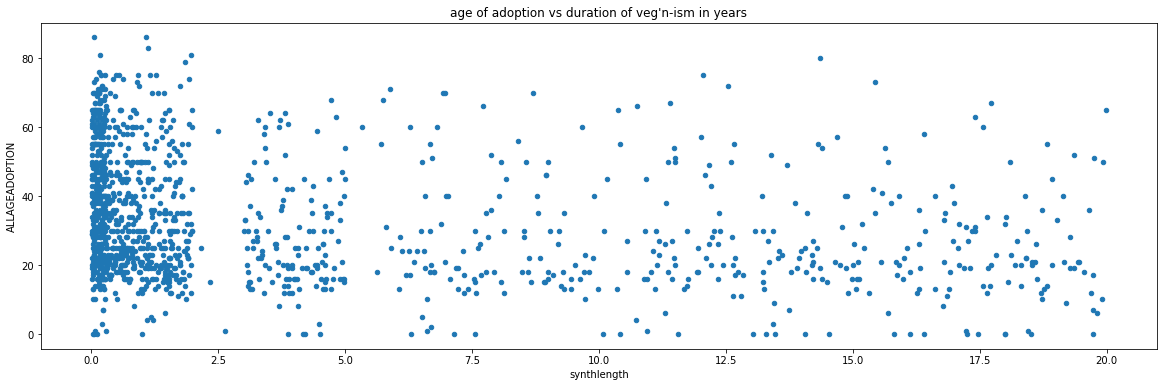

In [122]:
fig, ax = plt.subplots(1,1, figsize=(20,6))
data[['synthlength', 'ALLAGEADOPTION']].plot(kind='scatter', x='synthlength', y='ALLAGEADOPTION', ax=ax);
ax.set_title('age of adoption vs duration of veg\'n-ism in years');

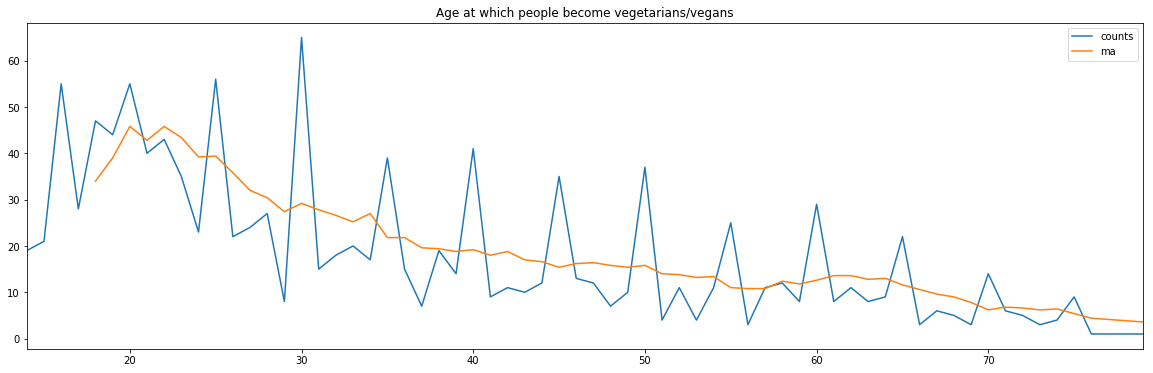

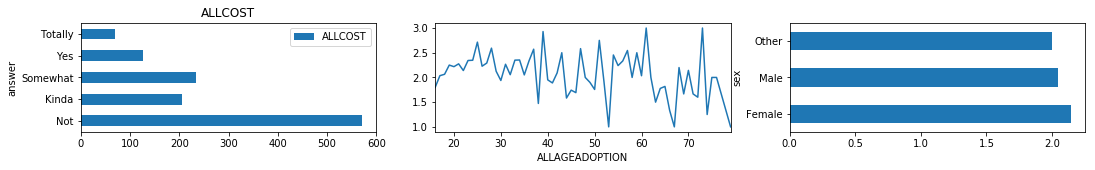

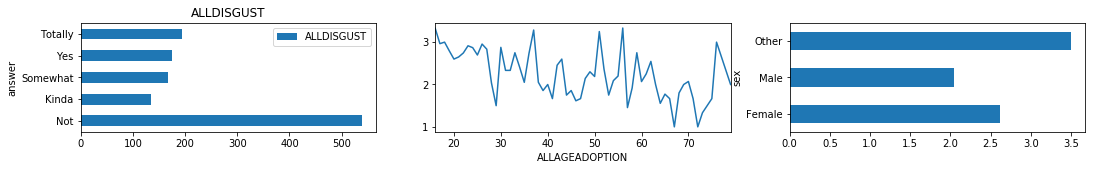

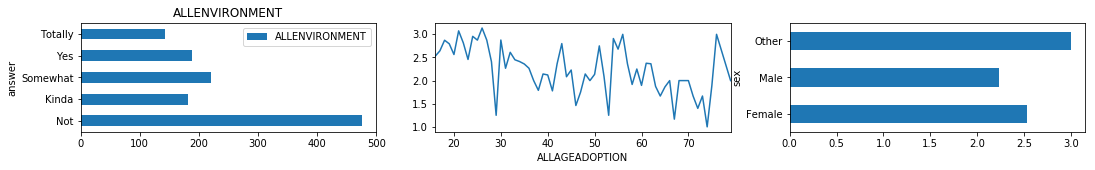

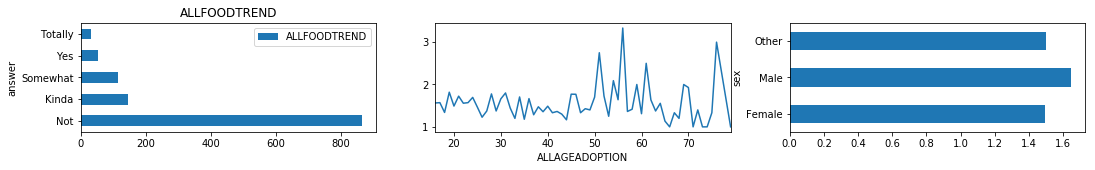

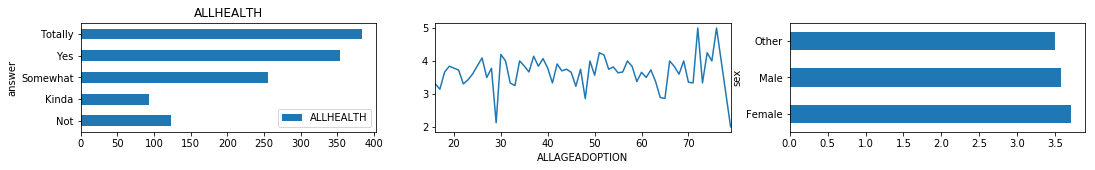

In [104]:
def motivations(motivation):
    fig, axs = plt.subplots(1,3, figsize=(18,2))
    table = span[motivation].value_counts().to_frame().sort_index()
    table['answer'] = ['Not', 'Kinda', 'Somewhat', 'Yes', 'Totally']
    table.set_index('answer', inplace=True)
    
    table.plot(ax=axs[0], kind='barh', title=motivation);
    span[span.ALLAGEADOPTION > 15].groupby('ALLAGEADOPTION')[motivation].mean().plot(ax=axs[1])
    span[span.ALLAGEADOPTION > 15].groupby('sex')[motivation].mean().plot(ax=axs[2], kind='barh')

    #table.plot(ax=ax, title=motivation);
    #print table

fig, ax = plt.subplots(1,1, figsize=(20,6))
age.plot(ax=ax, title='Age at which people become vegetarians/vegans');
motivations('ALLCOST')
motivations('ALLDISGUST')
motivations('ALLENVIRONMENT')
motivations('ALLFOODTREND')
motivations('ALLHEALTH')


|  These two plots don't agree.  hmmm


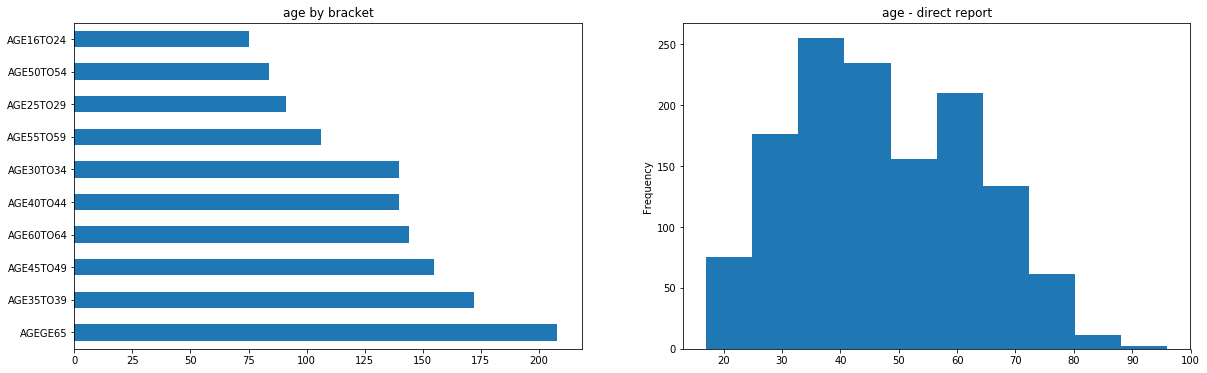

In [131]:
# current age of participants

#for c in data.columns:
#    if 'AGE' in c:
#        if c != 'ALLAGEADOPTION':
#            print c, data[c].value_counts()


ageranges = ['AGE16TO24','AGE25TO29','AGE25TO29','AGE30TO34','AGE35TO39','AGE40TO44',\
              'AGE45TO49','AGE50TO54','AGE55TO59','AGE60TO64','AGEGE65']

data['age_lowerbound'] = np.nan
data['age_upperbound'] = np.nan
data['age_class']      = np.nan
for ar in ageranges:
    # fill lower bound and upper bound for each row if there's a 1 in the 'ar' column for that row
    indices = data[data[ar] == 1].index
    lowerbound = 0
    upperbound = 0
    if ar == 'AGEGE65':
        lowerbound = 65
        upperbound = 100
    else:
        matches = re.search(r'AGE(\d+)TO(\d+)', ar)
        lowerbound = matches.group(1)
        upperbound = matches.group(2)
        
    data.set_value(indices, 'age_lowerbound', lowerbound)
    data.set_value(indices, 'age_upperbound', upperbound)
    data.set_value(indices, 'age_class', ar)

#print data.age_lowerbound.value_counts()
#print data.age_upperbound.value_counts()
#print data.age_class.value_counts()

fig, axs = plt.subplots(1,2, figsize=(20,6))
data.age_class.value_counts().plot(kind='barh', ax=axs[0], title='age by bracket');
data['ALL_1NEW'].plot(ax=axs[1], kind='hist', title='age - direct report');
print "|  These two plots don't agree.  hmmm"

Older people are more heavily represented in the data.  Consider taking 75 randomly chosen samples from each of the age ranges to bring the cohorts into balance.

In [ ]:
with s.SavHeaderReader(file) as header:
    metadata = header.all()
    report = str(header)
#print(metadata.valueLabels)
#print(report)
#df['AGEADOPTION0TO14'].unique()#.plot()
#df['ALLANIMALPROTECTIOND'].unique()#.plot()

#df[['token','submitdate','startlanguage','startdate','datestamp', 'ALL_1_1', 'ALL_1_2','HEALTHANIMALATLEASTONEOTHER']]
#df.columns